In [ ]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install statsmodels
!pip3 install -U scikit-learn scipy matplotlib

In [18]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [32]:
sales = pd.read_csv('data/Daily net retail sales 5 May 2000  6 April 2003.csv', index_col=0)
sales['x'] = sales['x'].fillna(sales['x'].mean())
sales.isnull().sum()
df = sales


In [33]:
df.describe()

,x
count,1067.000000
mean,257209.361963
std,130130.643359
min,101105.000000
25%,176416.500000
50%,217989.000000
75%,276230.500000
max,986587.000000


In [34]:
df.head()

,x
1,257209.361963
2,257209.361963
3,257209.361963
4,201468.000000
5,284033.000000


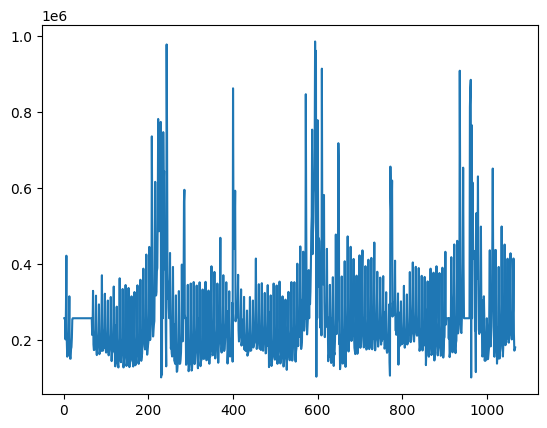

In [35]:
plt.plot(sales['x'])

In [36]:
from statsmodels.tsa.stattools import adfuller

def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [37]:
df_test('Продажи', df['x'])

Тест Дики-Фуллера ряда Продажи:
Test Statistic                   -4.699714
p-value                           0.000084
#Lags Users                      22.000000
Number of Observations Used    1044.000000
Critical Value (1%)              -3.436629
Critical Value (5%)              -2.864312
Critical Value (10%)             -2.568246
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [41]:
nottrend = []
s = 6
notseason = []

# выборка без тренда
for i in range(1, len(df['x'])):
    nottrend.append(df['x'].iloc[i] - df['x'].iloc[i-1])

# выборка без сезонности    
for i in range(s, len(df['x'])):
    notseason.append(df['x'].iloc[i] - df['x'].iloc[i-s])


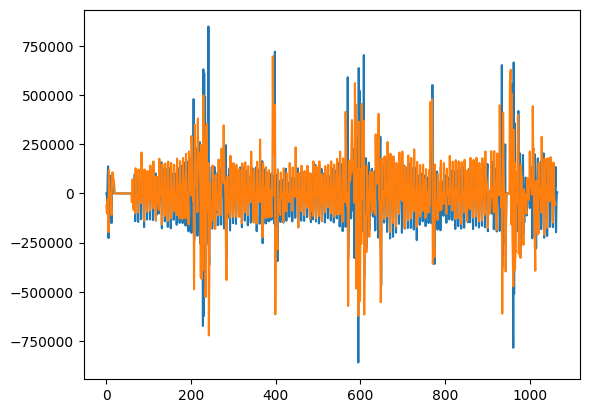

In [42]:
plt.plot(nottrend)
plt.plot(notseason)

In [43]:
df_test('не тренд', notseason)

Тест Дики-Фуллера ряда не тренд:
Test Statistic                -8.388297e+00
p-value                        2.404825e-13
#Lags Users                    2.200000e+01
Number of Observations Used    1.038000e+03
Critical Value (1%)           -3.436666e+00
Critical Value (5%)           -2.864328e+00
Critical Value (10%)          -2.568255e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


-0.8597828538036343


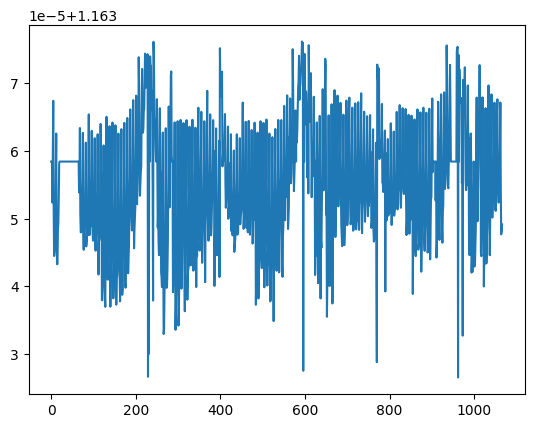

In [45]:
from scipy.stats import boxcox

# Преобразование Бокса-Кокса
transformed_data, best_lambda = boxcox(df['x'])

print(best_lambda)
plt.plot(transformed_data)

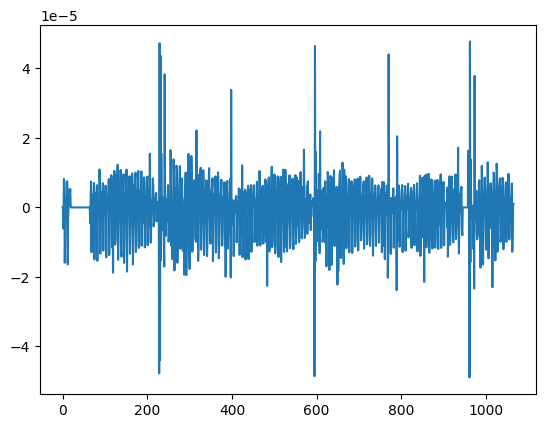

In [46]:
pnottrend = []

for i in range(1, len(transformed_data)):
    pnottrend.append(transformed_data[i] - transformed_data[i-1])

plt.plot(pnottrend)

In [47]:
df_test('Бокса-Кокса', pnottrend)

Тест Дики-Фуллера ряда Бокса-Кокса:
Test Statistic                -9.557011e+00
p-value                        2.483338e-16
#Lags Users                    2.200000e+01
Number of Observations Used    1.043000e+03
Critical Value (1%)           -3.436635e+00
Critical Value (5%)           -2.864315e+00
Critical Value (10%)          -2.568248e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


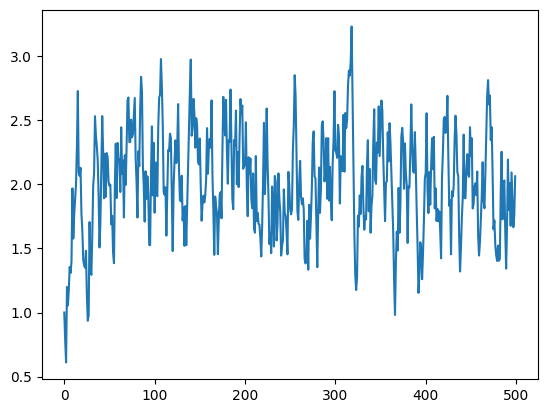

In [48]:
# AR(1)

N = 500

ar1 = [1]
ar1_minus = [1]
ar3 = [1]
for i in range(1, N):
    ar1.append(0.76 * ar1[i-1] + np.random.random())
    ar1_minus.append(-0.76 * ar1_minus[i-1] + np.random.random())
    ar3.append(2 * ar3[i-1] + np.random.random())



plt.plot(ar1)

In [49]:
print(f"standart deviation = {np.std(ar1)}\nmean = {np.mean(ar1)}")

standart deviation = 0.40040679022419967
mean = 2.012462676400074


In [50]:
def plot_ar1(name: list) -> None:
    ts = pd.DataFrame(name)

    fig = plt.figure(figsize=(20, 9))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    ts.plot(ax=ts_ax)
    ts_ax.set_title('Time Series Analysis Plots')
    smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(ts, lags=20, ax=pacf_ax, alpha=0.5)

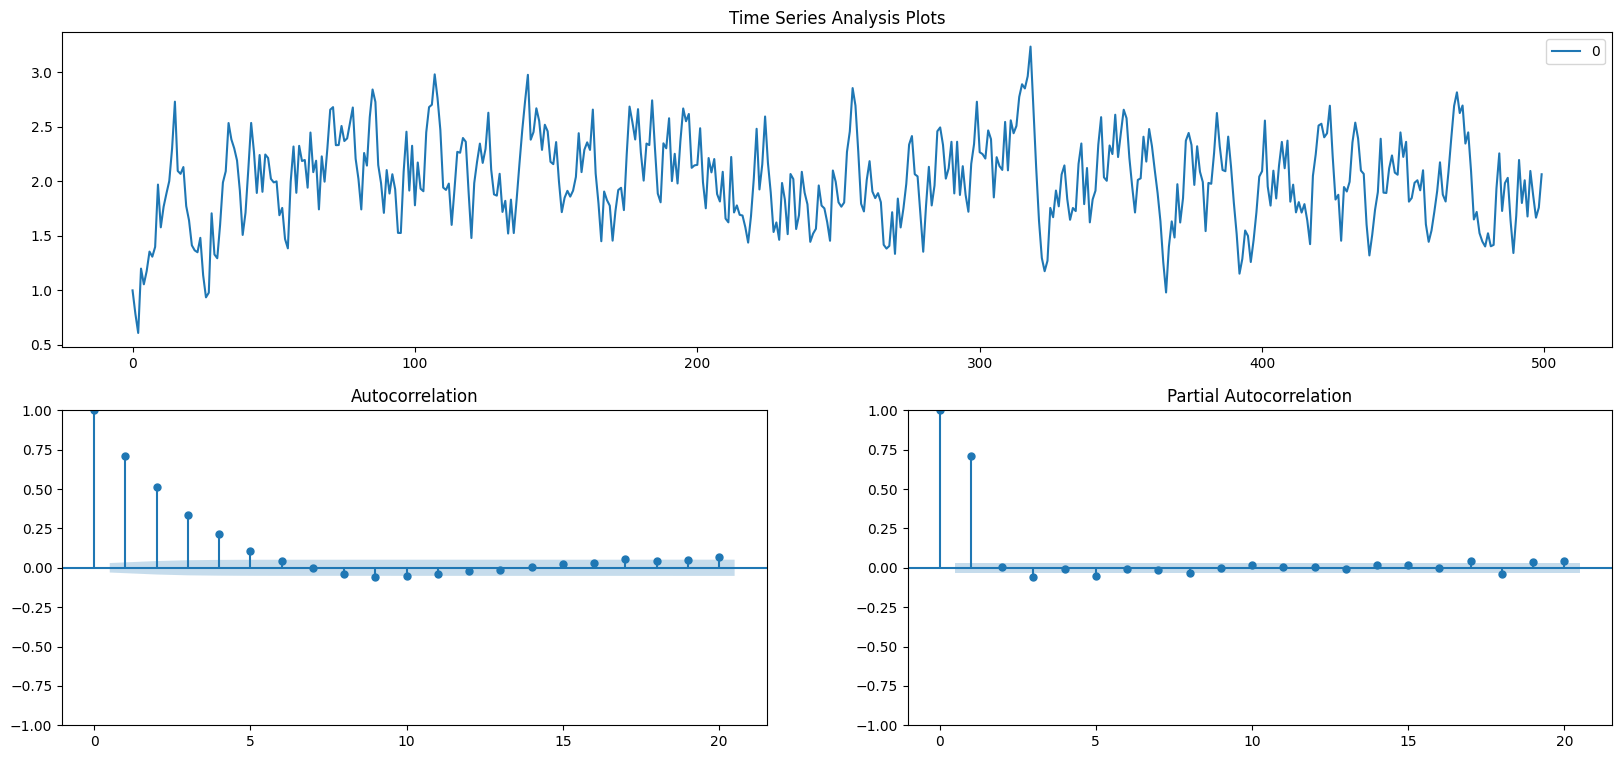

In [51]:
plot_ar1(ar1)

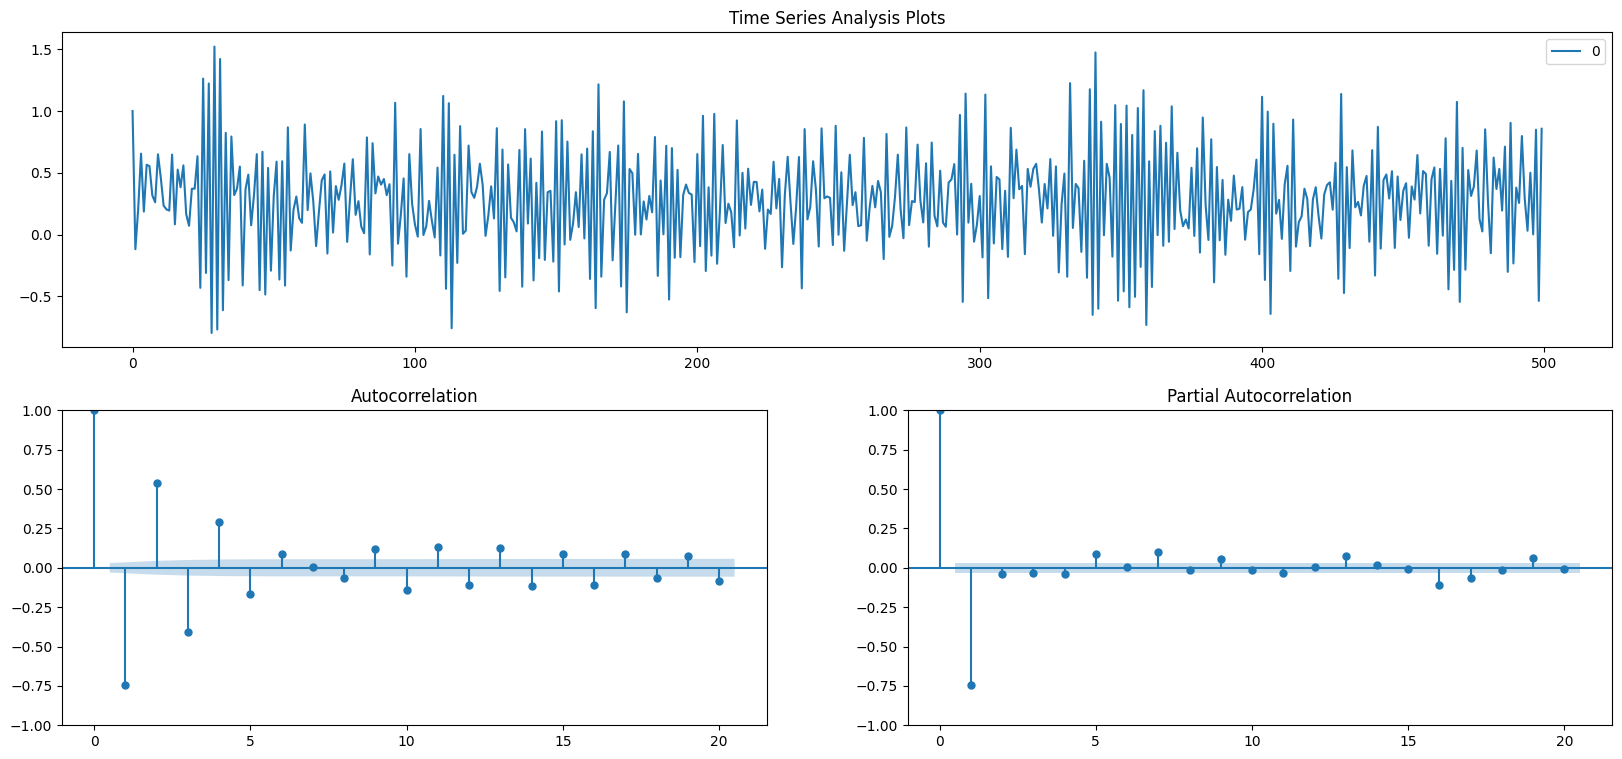

In [52]:
plot_ar1(ar1_minus)

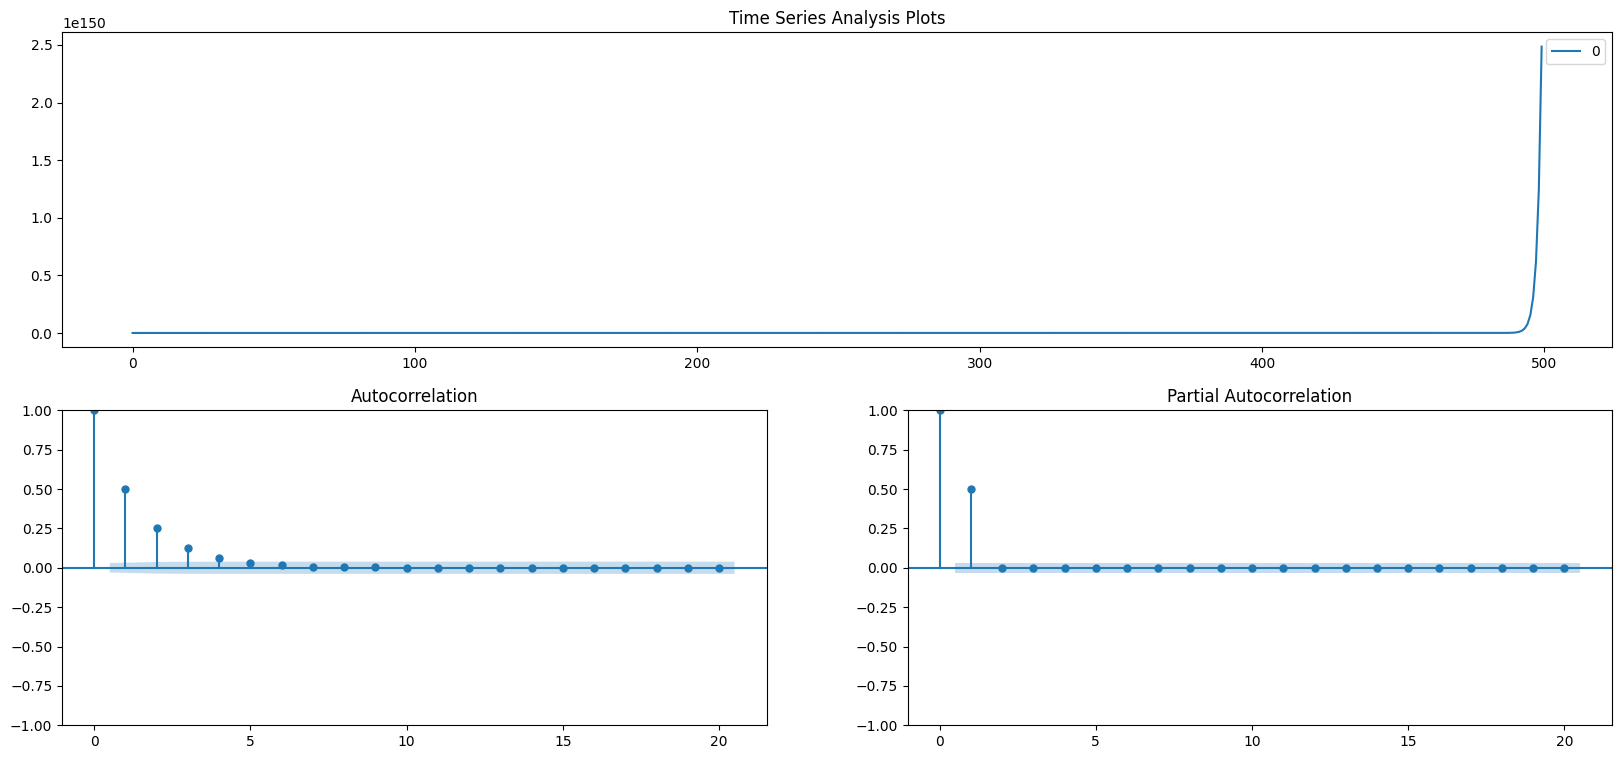

In [53]:
plot_ar1(ar3)

In [55]:
df = pd.read_csv('data/Daily net retail sales 5 May 2000  6 April 2003.csv',
                 names=['n', 'x'], skiprows=1)
df['x'] = df['x'].fillna(df['x'].mean())

df['t'] = df.index.values

ln = len(df)

# указываем 'объёмы' выборок
train_cutoff = int(round(ln * 0.75, 0))
validate_cutoff = int(round(ln * 0.90, 0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

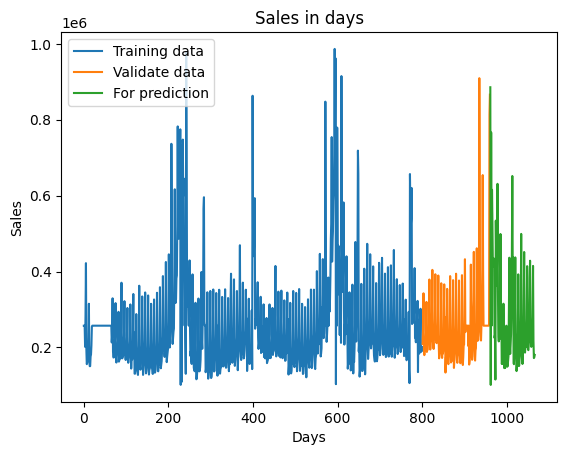

In [73]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Sales in days')
plt.ylabel('Sales')
plt.xlabel('Days')
plt.show()

In [74]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [75]:
mod = AutoReg(df.t, 3, old_names=False)
res = mod.fit()

print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                 1067
Model:                     AutoReg(3)   Log Likelihood               25359.793
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Mon, 09 Oct 2023   AIC                         -50709.587
Time:                        02:31:06   BIC                         -50684.738
Sample:                             3   HQIC                        -50700.171
                                 1067                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667    2.2e-13   3.03e+12      0.000       0.667       0.667
t.L1           1.0000    2.2e-13   4.55e+12      0.000       1.000       1.000
t.L2           0.3333   3.58e-16    9.3e+14      0.0

In [76]:
sel = ar_select_order(df.x, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                 1067
Model:                     AutoReg(9)   Log Likelihood              -13656.432
Method:               Conditional MLE   S.D. of innovations          97620.473
Date:                Mon, 09 Oct 2023   AIC                          27334.865
Time:                        02:31:08   BIC                          27389.470
Sample:                             9   HQIC                         27355.562
                                 1067                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.403e+04   9741.906      5.546      0.000    3.49e+04    7.31e+04
x.L1           0.3132      0.030     10.321      0.000       0.254       0.373
x.L2           0.2251      0.032      7.079      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


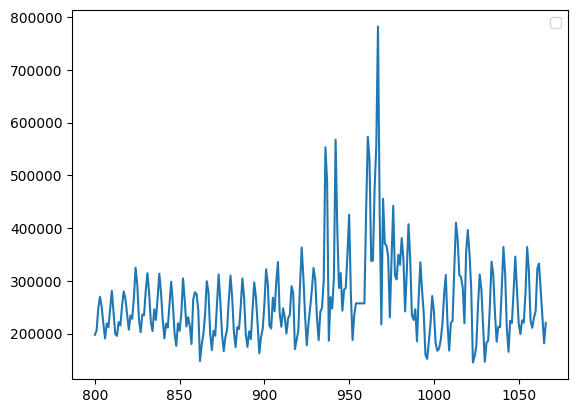

In [77]:
# смотрим, что предсказал
fig = res.plot_predict(train_cutoff)

In [78]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff+1, end=(forecast_df.t[len(df.t) - 1]), dynamic=False)

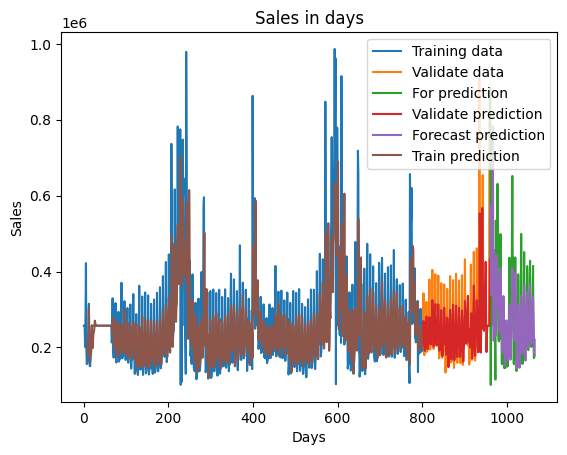

In [79]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction')
plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.title('Sales in days')
plt.ylabel('Sales')
plt.xlabel('Days')
plt.show()

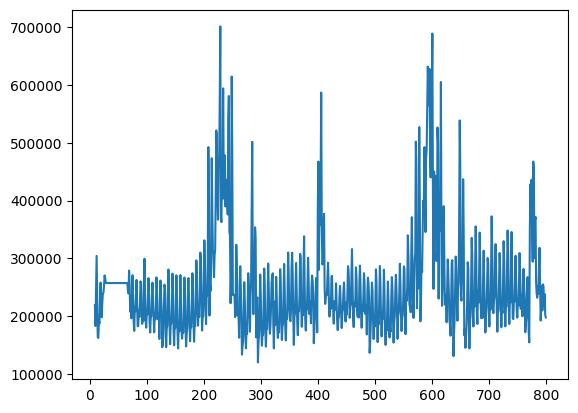

In [80]:
plt.plot(pred)

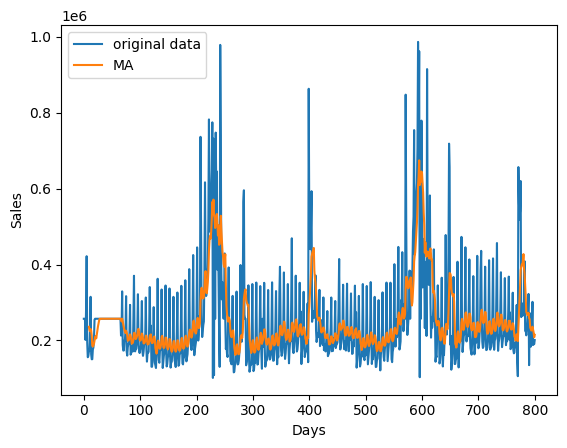

In [81]:
# MA

df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

plt.plot(train_df["t"], train_df["x"], label="original data")
plt.plot(train_df["t"], train_df["x"].rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Sales')
plt.xlabel('Days')
plt.show()

Метрики прогноза

In [86]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [87]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))

RMSE: 115490.71473353119
MAPE: 0.2850455543230514
MAE: 74856.64428300798
R2:  0.33734375754106327
